# Machine Learning for Level Truncation in String Field Theory

Consider the data of lumps in bosonic String Field Theory (SFT) and extrapolate level-$\infty$ predictions from finite level data.

## Setup

First of all we print the characteristics of the current setup (OS, cores, etc.):

In [1]:
from mltools.libos import InfoOS

print('Current OS:                  {} (kernel release: {}, architecture: {})'.format(InfoOS().os, InfoOS().kernel, InfoOS().arch))
print('Number of available threads: {:d}'.format(InfoOS().threads))
print('Current CPU frequency:       {:.0f} MHz (max: {:.0f} MHz)'.format(InfoOS().freq, InfoOS().freqm))
print('Available RAM memory:        {:d} MB (tot: {:d} MB)'.format(InfoOS().vmav, InfoOS().vmtot))

Current OS:                  Linux (kernel release: 5.6.11-arch1-1, architecture: x86_64)
Number of available threads: 8
Current CPU frequency:       2825 MHz (max: 3800 MHz)
Available RAM memory:        8179 MB (tot: 15758 MB)


We establish early in the notebook the amount of cores we want to use in order to parallelize computations:

In [2]:
n_jobs = int(InfoOS().threads / 4)

We then check the installed versions of the packages we are going to use:

In [3]:
import sys

import matplotlib as mpl
import random     as rnd
import sklearn    as skl
import numpy      as np
import pandas     as pd

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # ignore user warnings: nothing that I can really do anything about it...


%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# print the version of the modules
print('Python version: {:d}.{:d}'      .format(sys.version_info.major, sys.version_info.minor))
print('Matplot version: {}'            .format(mpl.__version__))
print('Numpy version: {}'              .format(np.__version__))
print('Pandas version: {}'             .format(pd.__version__))
print('Scikit-learn version: {}'       .format(skl.__version__))

# fix random_seed
RAND = 42
rnd.seed(RAND)
np.random.seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.4
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1


## Session Preparation

In order to save the results of the analysis, we need to create the structure of directories in the current repository:

In [4]:
from os import path, makedirs

ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ directory of images
MOD_DIR  = 'models' #--------------------------------------------- directory of saved models
LOG_DIR  = 'log' #------------------------------------------------ directory of logs
OUT_DIR  = 'output' #--------------------------------------------- directory for saved predictions, relevant output, etc.

DB_NAME = 'data_sft_dict' #--------------------------------------- name of the dataset
DB_FILE = DB_NAME + '.json' #------------------------------------- full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
OUT_PATH = path.join(ROOT_DIR, OUT_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok=True)

Then create a logging session to store debug information:

In [5]:
import logging

from mltools.liblog import create_logfile

path_to_log = path.join(LOG_PATH,
                        DB_NAME + '.log'
                       ) #----------------------------------------------------- log path
log = create_logfile(path_to_log,
                     name=DB_NAME,
                     level=logging.DEBUG
                    ) #-------------------------------------------------------- create log file and session

# these lines provide the same setup also for the Jupyter logging
logger = logging.getLogger() #------------------------------------------------- get the current logging session

fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s') #-------- customise the formatting options

handler = logging.StreamHandler() #-------------------------------------------- handle the stream to the default (stderr)
handler.setLevel(logging.DEBUG) #---------------------------------------------- print everything
handler.setFormatter(fmt) #---------------------------------------------------- set the formatting options

logger.handlers = [handler] #-------------------------------------------------- override the default stream

# we are ready to go!
log.info('New logging session started. Log is at {}.'.format(path_to_log))

Rotating existing logs...


2020-05-11 15:38:01,529: INFO ==> New logging session started. Log is at ./log/data_sft_dict.log.


## Import the Database

We then import the database from its JSON format and begin to analyse it:

In [6]:
if path.isfile(DB_PATH):
    df = pd.read_json(DB_PATH)
    log.debug('Database loaded.')
else:
    print('Database is not in the file tree!')
    log.error('Cannot find database!')

2020-05-11 15:38:01,557: DEBUG ==> Database loaded.


We then show the `dtypes` of each column to get an idea of the data structure:

In [7]:
df.dtypes

init      object
exp       object
weight    object
type      object
2         object
3         object
4         object
5         object
6         object
7         object
8         object
9         object
10        object
11        object
12        object
13        object
14        object
15        object
16        object
17        object
18        object
dtype: object

In the dataset we have the predictions of the position of lumps in bosonic SFT for finite levels in the numbered columns and the extrapolation for level-$\infty$ in the column _exp_. We want to use known data (including the _weight_ and the _type_ of the input data) to predict the _exp_ labels (_init_ in principle can be left out).

In [8]:
df.head(3)

,init,exp,weight,type,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.25, 1, 2.25, 4, 0, 0.25, ...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]",...,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]"
1,"[1.0001, 0, 1.0001, 1.0001, 1.0001, 1.0001, 0,...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.249950007499, 0.999800029...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000099754465899, -4.382819109385611e-08, 0....","[1.000099754261711, -6.385189815988693e-08, 0....","[1.000099495309939, -1.9972775228453091e-07, 0...","[1.000099494726808, -1.724421881015622e-07, 0....","[1.000099223845491, -3.2173432889712715e-07, 0...","[1.000099222907449, -2.856173963606407e-07, 0....",...,"[1.000098951488667, -3.9768513795577186e-07, 0...","[1.000098684133785, -5.470716468222031e-07, 0....","[1.000098682609473, -5.081256574169557e-07, 0....","[1.000098418312006, -6.559751804689415e-07, 0....","[1.000098416531483, -6.169537248661669e-07, 0....","[1.000098155198292, -7.630807670831046e-07, 0....","[1.000098153176776, -7.242020485026188e-07, 0....","[1.000097894670832, -8.685182838696036e-07, 0....","[1.000097892420157, -8.29888184051414e-07, 0.9...","[1.000097636616163, -9.72346758033437e-07, 0.9..."
2,"[1.001, 0, 1.001, 1.001, 1.001, 1.001, 0, 0, 0...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.24950074900124802, 0.9980...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000976232275641, -3.8820163895943e-06, 0.90...","[1.000976049237533, -5.9682788728782085e-06, 0...","[1.000952815386108, -1.689178344782202e-05, 0....","[1.000952352120989, -1.5047680126166993e-05, 0...","[1.000929855311967, -2.5515953552563565e-05, 0...","[1.000929190755388, -2.3264350581688953e-05, 0...",...,"[1.0009075350494, -3.03802946004187e-05, 0.664...","[1.000888236249875, -3.860013055708573e-05, 0....","[1.000887354078869, -3.657126395737419e-05, 0....","[1.000869431716091, -4.387998808033297e-05, 0....","[1.000868490272024, -4.199905525467674e-05, 0....","[1.000851773655717, -4.853491335211209e-05, 0....","[1.000850791489764, -4.6788451470318466e-05, 0...","[1.000835137520457, -5.266383019452565e-05, 0....","[1.000834127701389, -5.1036790056833293e-05, 0...","[1.000819417460843, -5.634321216588246e-05, 0...."


## Feature Extraction

We first add a column representing the index of the system in which the data are inserted. We also reorder the dataset to have the labels as last column and the index as first. We drop the `init` value as we do not intend to use it for predictions.

In [9]:
df['system'] = [[i] for i in df.index]
df = df[['system', 'type', 'weight', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', 'exp']]

We drop the first entry as it looks _suspiciously too perfect_ and might spoil the predictions. After that we reset the index:

In [10]:
df = df.iloc[1:].reset_index(drop=True)

We then shuffle the database a first time to keep each system together but in different order:

In [11]:
df = df.sample(frac=1, random_state=RAND)

We can now extract each feature and pad them to the same length in order to stack all entries on top of each others (we will take care of artificially created **duplicates** later):

In [12]:
from mltools.libtransformer import ExtractTensor

for n in range(df.shape[0]):
    df['system'].iloc[n] = df['system'].iloc[n] \
                         * np.prod(np.shape(df['type'].iloc[n])) #----------------------- reshape `system` to have same length as other columns in the same row
    
for feature in df:
    df[feature] = ExtractTensor(flatten=True).fit_transform(df[feature]) #--------------- extract features in the database

For every value in any column we want to extrapolate its level-$\infty$ predictions. We therefore need a way to extract each value from each column and treat the set of extracted numbers as different datasets to use for training.

In [13]:
# get the length of each entry after the extraction
length = np.max(df['exp'].apply(np.shape))[0]

# extract each correspondent values and "expand" them vertically
df = pd.concat([pd.DataFrame({f: df[f].str[n].values for f in df}) for n in range(length)], axis=0).reset_index(drop=True)
log.debug('Length of the spurious dataset: {:d} samples.'.format(df.shape[0]))

# show a couple of samples for reference
df.head(2)

2020-05-11 15:38:01,926: DEBUG ==> Length of the spurious dataset: 900 samples.


,system,type,weight,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,exp
0,40,2,0.0,1.169090,1.103953,1.049652,1.042422,1.025771,1.023925,1.016453,...,1.011730,1.011495,1.008954,1.008871,1.007160,1.007141,1.005919,1.00593,1.005018,1
1,26,2,0.0,1.133441,1.073850,1.041536,1.033556,1.022857,1.020416,1.015351,...,1.011415,1.010882,1.009026,1.008720,1.007436,1.007245,1.006306,1.00618,1.005465,1


## Finding Duplicates and Spurious Entries

Before proceeding any further we must then make sure that there are no **duplicate** rows in the database which would spoil the results as well as no **spurious** entries (namely those with `system` $= 0$ which were artificially introduced with the padding):

In [14]:
# delete spurious elements
df = df.loc[df['system'] > 0] #---------------------------- keep only system > 0

# drop duplicates
df = df.drop_duplicates(subset=None, keep='first') #------- do not use a subset of columns and keep only the first appearance

log.debug('Length of the correct dataset: {:d} samples.'.format(df.shape[0]))

2020-05-11 15:38:01,971: DEBUG ==> Length of the correct dataset: 718 samples.


The final dataset is as follows:

In [15]:
df.describe() #-------- this is a meaningful representation because we do not have categorical or object-like columns

,system,type,weight,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,exp
count,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,...,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,7.180000e+02,718.000000
mean,24.314763,3.749304,1.981686,-1.649589,-1.817170,7.981259,8.445939,-34.541055,-36.169106,172.934603,...,-752.288433,-776.523313,3061.210057,3147.716636,-11562.460857,-11855.258680,40629.386999,41566.669584,-1.334843e+05,0.541783
std,13.023788,0.662688,2.337013,4.548304,5.005473,21.558408,22.815235,111.039170,116.338079,613.372450,...,2852.135166,2942.302665,11912.541567,12240.685674,45391.801105,46512.063723,160087.941813,163698.216993,5.278422e+05,0.706857
min,1.000000,2.000000,0.000000,-19.744040,-21.893983,-0.754568,-0.782633,-514.984097,-538.627792,-0.909456,...,-13321.170445,-13781.246472,-8.850113,-12.265769,-211473.396816,-216475.644423,-44.356923,-66.596211,-2.489024e+06,-1.000000
25%,13.000000,4.000000,0.155340,-0.819357,-1.048764,0.000000,0.000000,-0.924887,-0.941950,0.000000,...,-1.122517,-2.123912,0.001518,0.001679,-3.214377,-6.185564,0.045728,0.042314,-2.569285e+01,0.000000
50%,25.000000,4.000000,1.000100,0.000000,0.000000,0.923914,0.935052,0.000000,0.000000,0.974117,...,0.001407,0.001712,0.987326,0.987066,0.001634,0.004821,1.004445,1.001084,9.732395e-02,1.000000
75%,36.000000,4.000000,3.213367,0.795133,0.913984,1.408763,1.552803,0.960644,0.984305,2.341926,...,0.991467,0.996329,4.397037,6.811820,0.997875,1.001248,16.098058,16.131990,1.003658e+00,1.000000
max,45.000000,4.000000,9.000000,1.239384,1.358098,122.931347,131.675490,2.275741,2.712998,2823.630938,...,5.243298,6.283092,56115.100219,57592.698860,16.106978,23.077325,731718.332090,748286.961169,1.033588e+02,1.000000


As a comment we must notice that in same cases there are _minimum_ and _maximum_ values which look like outliers (their absolute value seems to be too large). For the moment we will keep them in the dataset.

We save the dataset for further analysis:

In [16]:
df.to_hdf(path.join(ROOT_DIR, 'data_sft_analysis.h5'), key='data_sft', complevel=9, complib='bzip2')

## Training Set Preparation and Validation Strategy

In this case the division into training and test set can be a bit tricky. In fact we want to separate the samples according to their reference `system` in order to keep entries coming from the same "family" together. We will then keep 25% of the `system` values as test set, without regards to the effective number of samples in the set.

In [17]:
from sklearn.model_selection import train_test_split

system_train, system_test = train_test_split(df['system'].unique(), test_size=0.25, shuffle=True, random_state=RAND)

We then form the training and test sets using `system_train` and `system_test` as index:

In [18]:
df_train = df.loc[df['system'].isin(system_train)]
log.debug('Length of the training dataset: {:d} samples.'.format(df_train.shape[0]))

df_test  = df.loc[df['system'].isin(system_test)]
log.debug('Length of the test dataset: {:d} samples.'.format(df_test.shape[0]))

print('Training data: {:d}% of the dataset.'.format(int(100 * df_train.shape[0] / df.shape[0])))
print('Test data:     {:d}% of the dataset.'.format(int(100 * df_test.shape[0] / df.shape[0])))

2020-05-11 15:38:02,357: DEBUG ==> Length of the training dataset: 519 samples.
2020-05-11 15:38:02,361: DEBUG ==> Length of the test dataset: 199 samples.


Training data: 72% of the dataset.
Test data:     27% of the dataset.


We then experiment on the best validation split size for the analysis. We split the training set into an effective training set and a **holdout validation** set with several different sizes and use the **mean squared error** (MSE) as a metric to evaluate the algorithm against the validation set.

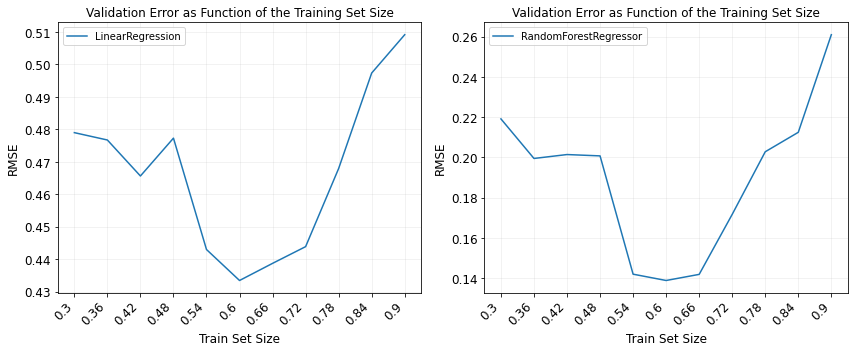

2020-05-11 15:38:06,211: DEBUG ==> Plot saved in ./img/rmse_train_size.pdf.


In [19]:
from sklearn.metrics      import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble     import RandomForestRegressor
from mltools.libplot      import Plot

# choose an estimator
estimators  = [LinearRegression(),
               RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=RAND)
              ]

# define the size of the train set we want to experiment
train_sizes = np.linspace(30, 90,
                          num=11,
                          dtype=np.int
                         ).reshape(1,-1) / 100.0 #------------------------------------------------- training sizes
rmse_values  = np.zeros((np.shape(estimators)[0], train_sizes.shape[1])) #------------------------- mse values (shape: n_estimators x train_sizes)

# iterate over the training set sizes
for n in range(train_sizes.shape[1]):
    # split the set and select the features
    train, val = train_test_split(df_train.drop(columns='system'), #------------------------------- drop the system column
                                  train_size=train_sizes[:,n].reshape(-1,),
                                  shuffle=True,
                                  random_state=RAND
                                 ) #--------------------------------------------------------------- split the training set
    train_features = train.drop(columns='exp') #--------------------------------------------------- training features
    val_features   = val.drop(columns='exp') #----------------------------------------------------- validation features

    train_label    = train['exp'] #---------------------------------------------------------------- training label
    val_label      = val['exp'] #------------------------------------------------------------------ validation label

    # evaluate the algorithm
    for m in range(np.shape(estimators)[0]):
        estimators[m].fit(train_features, train_label) #------------------------------------------- fit the estimator_1
        rmse_values[m,n] = np.sqrt(mean_squared_error(y_true=val_label,
                                                      y_pred=estimators[m].predict(val_features)
                                                     )
                                  )#--------------------------------------------------------------- store the values of the MSE

# plot the MSE values
plot = Plot(rows=1, columns=np.shape(estimators)[0])

for m in range(np.shape(estimators)[0]):
    plot.series2D(data=rmse_values[m,:],
                  axis=m,
                  title='Validation Error as Function of the Training Set Size',
                  xlabel='Train Set Size',
                  ylabel='RMSE',
                  legend=estimators[m].__class__.__name__,
                  labels=train_sizes.reshape(-1,)
                 )

plot.save_and_close(path.join(IMG_PATH, 'rmse_train_size'))
log.debug('Plot saved in {}.'.format(path.join(IMG_PATH, 'rmse_train_size.pdf')))

In the plot we show the progression of the MSE as a function of the training size. A good compromise between the no. of samples in the training set and the MSE of different kinds of algorithms seems to be around 60% to 70% of the dataset.

We will therefore divide the original training set as follows:

- 27% into a **test set** (already split),
- 25% into **cross-validation** splits (around 34% of the training dataset),
- 48% into the effective **training set** (around 66% of the training dataset).

When we implement cross-validation in _Scikit_ we will therefore use 3 splits.

In [20]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True, random_state=RAND)

## Machine Learning Analysis

We now move to the ML analysis of the dataset. Given the size of the dataframe, we will try different approaches to the extrapolation of the level-$\infty$ predictions. Specifically we will look at:

- [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to have a solid baseline for comparison,
- [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) to implement **L1** and **L2** regularizations,
- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) to implement **L2** regularization,
- [Linear SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html) to use **support vector machines** to improve the predictions,
- [SVR (Gaussian kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) to hopefully find better results,
- [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) to use the power of **decision trees** and **ensemble** learning,
- [Histogram Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) to improve the predictive abilities of a single decision tree through successive improvement.

For the hyperparameter optimization we use a [**Bayesan** approach](https://en.wikipedia.org/wiki/Bayesian_optimization) in the [_Scikit-optimize_](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) library: this will provide a better approach to the minimization of the cost functions during cross-validation with respect to a randomized search (apart from the linear regression where we will test all possible values of the hyperparameters). In order to print the output of the parameters dictionaries we implement a function to pretty print them:

In [21]:
def pretty(dct, indent=True):
    '''
    Pretty print the dictionary of best parameters.
    
    Required argument:
        dct:    the dictionary to pretty print.
        
    Optional argument:
        indent: whether to indent the printed output.
    '''
    
    for key, value in dct.items():
        if indent:
            print('    {} = {}'.format(key, value))
        else:
            print('{} = {}'.format(key, value))

### Features and Labels Extraction

We then extract the training features and the labels. If needed we can implement the scaling of the features.

In [22]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# drop the `system` column
df_train = df_train.drop(columns='system')
df_test  = df_test.drop(columns='system')

# features
features_train = df_train.drop(columns='exp')
features_test  = df_test.drop(columns='exp')

# scale the features
features_scaler = StandardScaler()

if features_scaler is not None:
    features_train = features_scaler.fit_transform(features_train)
    features_test  = features_scaler.transform(features_test)

# labels
labels_train = df_train['exp']
labels_test  = df_test['exp']

### [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

We first consider a linear regression algorithm. In this case the number of hyperparameters to be tuned is small and we can use a **grid search** to try out every combination:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$.

In [23]:
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import mean_squared_error
from mltools.libscore        import ViewCV
from mltools.libplot         import Plot

import joblib

# parameter dictionary
search_params  = {'fit_intercept': [0, 1],
                  'normalize':     [0, 1]
                 } #----------------------------------------------------------------------------- define hyperparameter grid

# optimization search
log.info('LINEAR REGRESSION')
lin_reg = GridSearchCV(estimator=LinearRegression(),
                       param_grid=search_params,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1,
                       refit=True,
                       cv=cv
                      ) #----------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the estimator...')
lin_reg.fit(features_train, labels_train)

# evaluate the estimator
log.info('Evaluating the estimator...')
cv_results = ViewCV(lin_reg)

print('\nBest parameters:\n')
pretty(cv_results.best_parameters)

print('\nRMSE on the validation set: {:.3f} ± {:.3f}'.format(np.sqrt(-cv_results.test_mean()),
                                                             np.sqrt(cv_results.test_std())
                                                            )
     )

2020-05-11 15:38:06,369: INFO ==> LINEAR REGRESSION
2020-05-11 15:38:06,371: INFO ==> Fitting the estimator...
2020-05-11 15:38:08,308: INFO ==> Evaluating the estimator...



Best parameters:

    fit_intercept = 1
    normalize = 1

RMSE on the validation set: 0.463 ± 0.159


### [Elastic Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

We then try to implement the regularized version of the simple linear regression: we use an **elastic net** because it implements both **L1** and **L2** regularizations and can be a guide in choosing the appropriate values. In fact the hyperparameters in this case allow to separately control the two different regularizations. The additional term (with respect to the linear regression) to the cost function is of the form $\Delta J(w) = \alpha l_{1\,ratio} \vert\vert w \vert\vert + \frac{\alpha}{2} (1 - l_{1\,ratio}) \vert\vert w \vert\vert^2$. We will then study the following hyperparamter space:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$,
- `alpha` $\in \left[ 10^{-2}, 10^2 \right]$,
- `l1_ratio` $\in \left[ 0.0, 1.0 \right]$.

In [24]:
from sklearn.linear_model import ElasticNet
from skopt                import BayesSearchCV
from skopt.space          import Real, Integer, Categorical
from sklearn.metrics      import mean_squared_error
from mltools.libscore     import ViewCV
from mltools.libplot      import Plot

import joblib

# parameter dictionary
search_params  = {'fit_intercept': Integer(0, 1),
                  'normalize':     Integer(0, 1),
                  'alpha':         Real(1.0e-2, 1.0e2, prior='log-uniform'),
                  'l1_ratio':      Real(0.0, 1.0, prior='uniform')
                 } #--------------------------------------------------------------------------- define hyperparameter grid

# optimization search
log.info('ELASTIC NET')
el_net = BayesSearchCV(estimator=ElasticNet(max_iter=1e5, random_state=RAND),
                       search_spaces=search_params,
                       scoring='neg_mean_squared_error',
                       n_jobs=-1,
                       refit=True,
                       n_iter=50,
                       random_state=RAND,
                       cv=cv
                      ) #---------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the estimator...')
el_net.fit(features_train, labels_train)

# evaluate the estimator
log.info('Evaluating the estimator...')
cv_results = ViewCV(el_net)

print('\nBest parameters:\n')
pretty(cv_results.best_parameters)

print('\nRMSE on the validation set: {:.3f} ± {:.3f}'.format(np.sqrt(-cv_results.test_mean()),
                                                             np.sqrt(cv_results.test_std())
                                                            )
     )

2020-05-11 15:38:08,424: INFO ==> ELASTIC NET
2020-05-11 15:38:08,425: INFO ==> Fitting the estimator...
2020-05-11 15:40:46,551: INFO ==> Evaluating the estimator...



Best parameters:

    alpha = 0.01
    fit_intercept = 1
    l1_ratio = 0.0
    normalize = 0

RMSE on the validation set: 0.579 ± 0.272


Notice that the values of $\alpha$ and $l_{1~ratio}$ seem to suggest the need for **L2** regularization procided by the **Ridge** regression which we implement as the next step. 

### [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

We try to implement the pure **L2** regularized linear model. We explore the hyperparameter space:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `normalize` $\in \lbrace 0, 1 \rbrace$,
- `alpha` $\in \left[ 10^{-2}, 10^2 \right]$.

In [25]:
from sklearn.linear_model import Ridge
from skopt                import BayesSearchCV
from skopt.space          import Real, Integer, Categorical
from sklearn.metrics      import mean_squared_error
from mltools.libscore     import ViewCV
from mltools.libplot      import Plot

import joblib

# parameter dictionary
search_params  = {'fit_intercept': Integer(0, 1),
                  'normalize':     Integer(0, 1),
                  'alpha':         Real(1.0e-2, 1.0e2, prior='log-uniform')
                 } #--------------------------------------------------------------------------- define hyperparameter grid

# optimization search
log.info('RIDGE')
ridge = BayesSearchCV(estimator=Ridge(random_state=RAND),
                      search_spaces=search_params,
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      refit=True,
                      n_iter=50,
                      random_state=RAND,
                      cv=cv
                     ) #---------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the estimator...')
ridge.fit(features_train, labels_train)

# evaluate the estimator
log.info('Evaluating the estimator...')
cv_results = ViewCV(ridge)

print('\nBest parameters:\n')
pretty(cv_results.best_parameters)

print('\nRMSE on the validation set: {:.3f} ± {:.3f}'.format(np.sqrt(-cv_results.test_mean()),
                                                             np.sqrt(cv_results.test_std())
                                                            )
     )

2020-05-11 15:40:46,594: INFO ==> RIDGE
2020-05-11 15:40:46,597: INFO ==> Fitting the estimator...
2020-05-11 15:42:30,419: INFO ==> Evaluating the estimator...



Best parameters:

    alpha = 0.01
    fit_intercept = 1
    normalize = 0

RMSE on the validation set: 0.531 ± 0.236


### [Linear SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html)

We move to the **support vector machines** (SVM) algorithms and start without a **kernel** function. We use the linear implementation of the support vector regressor with hyperparameters:

- `fit_intercept` $\in \lbrace 0, 1 \rbrace$,
- `epsilon` $\in \left[ 0.0, 1.0 \right]$,
- `C` $\in \left[ 10^{-1}, 10^3 \right]$,
- `loss` $\in \lbrace epsilon\_insensitive, squared\_epsilon\_insensitive \rbrace$,
- `intercept_scaling` $\in \left[ 10^{-2}, 10^2 \right]$.

In [26]:
from sklearn.svm      import LinearSVR
from skopt            import BayesSearchCV
from skopt.space      import Real, Integer, Categorical
from sklearn.metrics  import mean_squared_error
from mltools.libscore import ViewCV
from mltools.libplot  import Plot

import joblib

# parameter dictionary
search_params  = {'fit_intercept':     Integer(0, 1),
                  'epsilon':           Real(0.0, 1.0,  prior='uniform'),
                  'C':                 Real(1.0e-1, 1.0e3, prior='log-uniform'),
                  'intercept_scaling': Real(1.0e-2, 1.0e2, prior='log-uniform'),
                  'loss':              Categorical(['squared_epsilon_insensitive', 'epsilon_insensitive'])
                 } #----------------------------------------------------------------------------------- define hyperparameter grid

# optimization search
log.info('LINEAR SVR')
lin_svr = BayesSearchCV(LinearSVR(max_iter=1e5, random_state=RAND),
                        search_spaces=search_params,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        refit=True,
                        n_iter=50,
                        random_state=RAND,
                        cv=cv
                       ) #---------------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the estimator...')
lin_svr.fit(features_train, labels_train)

# evaluate the estimator
log.info('Evaluating the estimator...')
cv_results = ViewCV(lin_svr)

print('\nBest parameters:\n')
pretty(cv_results.best_parameters)

print('\nRMSE on the validation set: {:.3f} ± {:.3f}'.format(np.sqrt(-cv_results.test_mean()),
                                                             np.sqrt(cv_results.test_std())
                                                            )
     )

2020-05-11 15:42:30,470: INFO ==> LINEAR SVR
2020-05-11 15:42:30,472: INFO ==> Fitting the estimator...
2020-05-11 15:51:24,043: INFO ==> Evaluating the estimator...



Best parameters:

    C = 291.0760784596301
    epsilon = 0.20475887943766544
    fit_intercept = 1
    intercept_scaling = 5.8001415263948015
    loss = squared_epsilon_insensitive

RMSE on the validation set: 0.525 ± 0.192


### [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) (Gaussian Kernel)

We now implement a kernel function in the SVM. In particular we use the Gaussian kernel (_rbf_) and try to approximate the level-$\infty$ predictions using these hyperparameters:

- `gamma` $\in \left[ 10^{-1}, 10^1 \right]$,
- `C` $\in \left[ 10^{-1}, 5 \times 10^2 \right]$,
- `epsilon` $\in \left[ 10^{-4}, 10^{-1} \right]$,
- `shrinking` $\in \lbrace 0, 1 \rbrace$.

In [27]:
from sklearn.svm      import SVR
from skopt            import BayesSearchCV
from skopt.space      import Real, Integer, Categorical
from sklearn.metrics  import mean_squared_error
from mltools.libscore import ViewCV
from mltools.libplot  import Plot

import joblib

# parameter dictionary
search_params  = {'epsilon':   Real(1.0e-4, 1.0e-1, prior='log-uniform'),
                  'C':         Real(1.0e-1, 5.0e2,  prior='log-uniform'),
                  'gamma':     Real(1.0e-1, 1.0e1,  prior='log-uniform'),
                  'shrinking': Integer(0, 1)
                 } #----------------------------------------------------------------------------------- define hyperparameter grid

# optimization search
log.info('SVR')
svr = BayesSearchCV(SVR(kernel='rbf'),
                    search_spaces=search_params,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    refit=True,
                    n_iter=50,
                    random_state=RAND,
                    cv=cv
                   ) #-------------------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the estimator...')
svr.fit(features_train, labels_train)

# evaluate the estimator
log.info('Evaluating the estimator...')
cv_results = ViewCV(svr)

print('\nBest parameters:\n')
pretty(cv_results.best_parameters)

print('\nRMSE on the validation set: {:.3f} ± {:.3f}'.format(np.sqrt(-cv_results.test_mean()),
                                                             np.sqrt(cv_results.test_std())
                                                            )
     )

2020-05-11 15:51:24,071: INFO ==> SVR
2020-05-11 15:51:24,074: INFO ==> Fitting the estimator...
2020-05-11 15:55:16,622: INFO ==> Evaluating the estimator...



Best parameters:

    C = 499.99999999999994
    epsilon = 0.0001
    gamma = 1.8158720638335621
    shrinking = 1

RMSE on the validation set: 0.200 ± 0.124


### [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Moving on to the **decision tree** family of algorithms, we implement the **random forest** regression in the _Scikit_ implementation. We will try to intervene on as many hyperparameters as possible both to avoid overfitting the training set and to be able to generalise to new results. We use the following hyperparameters:

- `n_estimators` $\in \left[ 10, 300 \right]$,
- `criterion` $\in \lbrace mse, mae \rbrace$,
- `max_depth` $\in \left[ 2, 100 \right]$,
- `min_samples_split` $\in \left[ 2, 100 \right]$,
- `min_samples_leaf` $\in \left[ 1, 100 \right]$,
- `min_weight_fraction_leaf` $\in \left[ 0, 0.5\right]$,
- `max_leaf_nodes` $\in \left[ 2, 100 \right]$.

In [28]:
from sklearn.ensemble import RandomForestRegressor
from skopt            import BayesSearchCV
from skopt.space      import Real, Integer, Categorical
from sklearn.metrics  import mean_squared_error
from mltools.libscore import ViewCV
from mltools.libplot  import Plot

import joblib

# parameter dictionary
search_params = {'n_estimators':             Integer(1.0e1, 3.0e2, prior='log-uniform'),
                 'max_depth':                Integer(2, 100, prior='uniform'),
                 'min_samples_split':        Integer(2, 100, prior='uniform'),
                 'min_samples_leaf':         Integer(1, 100, prior='uniform'),
                 'max_leaf_nodes':           Integer(2, 100, prior='uniform'),
                 'min_weight_fraction_leaf': Real(0.0, 0.5, prior='uniform'),
                 'criterion':                Categorical(['mse', 'mae'])
                } #------------------------------------------------------------------------------------ define hyperparameter grid

# optimization search
log.info('RANDOM FOREST')
rnd_for = BayesSearchCV(RandomForestRegressor(n_jobs=-1, random_state=RAND),
                        search_spaces=search_params,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1,
                        refit=True,
                        n_iter=25,
                        random_state=RAND,
                        cv=cv
                       ) #---------------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the estimator...')
rnd_for.fit(features_train, labels_train)

# evaluate the estimator
log.info('Evaluating the estimator...')
cv_results = ViewCV(rnd_for)

print('\nBest parameters:\n')
pretty(cv_results.best_parameters)

print('\nRMSE on the validation set: {:.3f} ± {:.3f}'.format(np.sqrt(-cv_results.test_mean()),
                                                             np.sqrt(cv_results.test_std())
                                                            )
     )

2020-05-11 15:55:16,657: INFO ==> RANDOM FOREST
2020-05-11 15:55:16,659: INFO ==> Fitting the estimator...
2020-05-11 15:56:29,173: INFO ==> Evaluating the estimator...



Best parameters:

    criterion = mse
    max_depth = 32
    max_leaf_nodes = 18
    min_samples_leaf = 1
    min_samples_split = 14
    min_weight_fraction_leaf = 0.0
    n_estimators = 170

RMSE on the validation set: 0.166 ± 0.060


### [Histogram Based Gradient Boosting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

We consider the new (still _experimental_) version of _Scikit_ **gradient boosting** algorithm, which is **histogram bases**. This should automatically handle _NaN_ gradients and be quite faster than the usual implementation. We will consider the followin hyperparameters:

- `loss` $\in \lbrace least\_squares, least\_absolute\_deviation \rbrace$,
- `learning_rate` $\in \left[ 10^{-4}, 10^{-1} \right]$,
- `max_iter` $\in \left[ 10, 300 \right]$,
- `max_depth` $\in \left[ 2, 100 \right]$,
- `min_samples_leaf` $\in \left[ 10, 100 \right]$,
- `l2_regularization` $\in \left[ 10^{-6}, 10^2 \right]$,
- `max_leaf_nodes` $\in \left[ 2, 50 \right]$.

In [29]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble     import HistGradientBoostingRegressor
from skopt                import BayesSearchCV
from skopt.space          import Real, Integer, Categorical
from sklearn.metrics      import mean_squared_error
from mltools.libscore     import ViewCV
from mltools.libplot      import Plot

import joblib

# parameter dictionary
search_params = {'max_iter':          Integer(1.0e1, 3.0e2, prior='log-uniform'),
                 'max_depth':         Integer(2, 100,  prior='uniform'),
                 'max_leaf_nodes':    Integer(2, 50,   prior='uniform'),
                 'min_samples_leaf':  Integer(10, 100, prior='uniform'),
                 'learning_rate':     Real(1.0e-4, 1.0e-1, prior='log-uniform'),
                 'l2_regularization': Real(1.0e-6, 1.0e2,  prior='log-uniform'),
                 'loss':              Categorical(['least_squares', 'least_absolute_deviation'])
                } #------------------------------------------------------------------------------------- define the hyperparameter grid

# optimization search
log.info('BOOSTED TREES')
grd_boost = BayesSearchCV(HistGradientBoostingRegressor(scoring='loss', validation_fraction=None, n_iter_no_change=10, random_state=RAND),
                          search_spaces=search_params,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          refit=True,
                          n_iter=25,
                          random_state=RAND,
                          cv=cv
                         ) #--------------------------------------------------------------------------- define the optimization estimator

# fit the estimator
log.info('Fitting the estimator...')
grd_boost.fit(features_train, labels_train)

# evaluate the estimator
log.info('Evaluating the estimator...')
cv_results = ViewCV(grd_boost)

print('\nBest parameters:\n')
pretty(cv_results.best_parameters)

print('\nRMSE on the validation set: {:.3f} ± {:.3f}'.format(np.sqrt(-cv_results.test_mean()),
                                                             np.sqrt(cv_results.test_std())
                                                            )
     )

2020-05-11 15:56:29,209: INFO ==> BOOSTED TREES
2020-05-11 15:56:29,213: INFO ==> Fitting the estimator...
2020-05-11 16:07:55,619: INFO ==> Evaluating the estimator...



Best parameters:

    l2_regularization = 0.00524404052618982
    learning_rate = 0.05234588205580838
    loss = least_squares
    max_depth = 41
    max_iter = 92
    max_leaf_nodes = 16
    min_samples_leaf = 10

RMSE on the validation set: 0.139 ± 0.072


## Discussion and Test Set Performance

It seems that in general the **linear models** perform at best when **no regularization** is involved, thus the simple **linear regression** model represents a very good baseline for improvement. The **support vector machines** perform better in the presence of a kernel function (**Gaussian** in this case) and improve the results of the linear regression. In principle also the **random forest** regression is a very good prediction algorithm in this case even though it is strongly influenced by the presence of the initial values in the dataset. However, in the family of decision trees, the **boosted trees** vastly outperform the random forest, especially when the initial values are not present. 

Notice that we applied a scaler at the beginning in order to improve the convergence of the algorithms.

In [30]:
import joblib

from sklearn.metrics import mean_squared_error

print('RMSE of the linear regression on the test set: {:.3f}'.format(np.sqrt(mean_squared_error(y_true=labels_test, y_pred=lin_reg.best_estimator_.predict(features_test)))))
print('RMSE of the elastic net on the test set:       {:.3f}'.format(np.sqrt(mean_squared_error(y_true=labels_test, y_pred=el_net.best_estimator_.predict(features_test)))))
print('RMSE of the ridge on the test set:             {:.3f}'.format(np.sqrt(mean_squared_error(y_true=labels_test, y_pred=ridge.best_estimator_.predict(features_test)))))
print('RMSE of the linear svr on the test set:        {:.3f}'.format(np.sqrt(mean_squared_error(y_true=labels_test, y_pred=lin_svr.best_estimator_.predict(features_test)))))
print('RMSE of the svr on the test set:               {:.3f}'.format(np.sqrt(mean_squared_error(y_true=labels_test, y_pred=svr.best_estimator_.predict(features_test)))))
print('RMSE of the random forest on the test set:     {:.3f}'.format(np.sqrt(mean_squared_error(y_true=labels_test, y_pred=rnd_for.best_estimator_.predict(features_test)))))
print('RMSE of the boosted trees on the test set:     {:.3f}'.format(np.sqrt(mean_squared_error(y_true=labels_test, y_pred=grd_boost.best_estimator_.predict(features_test)))))

RMSE of the linear regression on the test set: 0.376
RMSE of the elastic net on the test set:       0.522
RMSE of the ridge on the test set:             0.454
RMSE of the linear svr on the test set:        0.479
RMSE of the svr on the test set:               0.099
RMSE of the random forest on the test set:     0.035
RMSE of the boosted trees on the test set:     0.025


We then save the predictions to a JSON file for later use:

In [31]:
import json

predictions = {'labels': labels_test.values.tolist(),
               'lin_reg': lin_reg.predict(features_test).tolist(),
               'el_net':  el_net.predict(features_test).tolist(),
               'ridge':   ridge.predict(features_test).tolist(),
               'lin_svr': lin_svr.predict(features_test).tolist(),
               'svr_rbf': svr.predict(features_test).tolist(),
               'rnd_for': rnd_for.predict(features_test).tolist(),
               'grd_boost': grd_boost.predict(features_test).tolist(),
              }

with open(path.join(OUT_PATH, 'sft_level_trunc_predictions.json'), 'w') as f:
    json.dump(predictions, f)
    
log.debug('Predictions saved to {}'.format(path.join(OUT_PATH, 'sft_level_trunc_predictions.json')))

2020-05-11 16:08:08,965: DEBUG ==> Predictions saved to ./output/sft_level_trunc_predictions.json
